# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [91]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


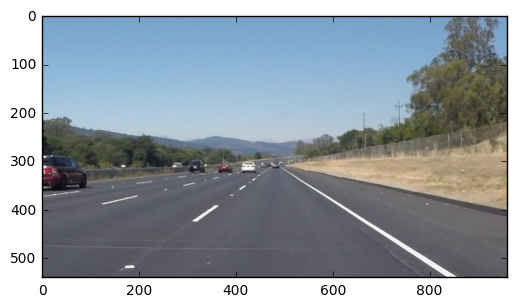

In [92]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [146]:

class LaneDetection:
    def __init__(self):
        """
        Set parameters and thresholds used in LaneDetection class.
        Initialize internal variables
        """

        # Parameters for gaussian blur
        self.kernel_size = 5

        # Threshold used for canny edge detection
        self.low_threshold = 100
        self.high_threshold = 200

        # Parameters used in hough transformation
        self.rho = 1  # distance resolution in pixels of the Hough grid
        self.theta = np.pi / 180  # angular resolution in radians of the Hough grid
        self.hough_threshold = 1  # minimum number of votes (intersections in Hough grid cell)
        self.min_line_length = 10  # minimum number of pixels making up a line
        self.max_line_gap = 2  # maximum gap in pixels between connectable line segments

        # Internal storage
        self._imageShape = (0,0)

    def run(self, img):
        """

        """

        # Update internal storage
        self._imageShape = img.shape

        # Run image processing pipeline
        imgGrayscale = self.convertToGrayscale(img)
        imgGaussian = self.runGaussianBlur(imgGrayscale)
        imgCanny = self.runCanny(imgGaussian)
        imgMasked = self.maskImage(imgCanny)
        imgHoughLines = self.runHoughLines(imgMasked)
        imgWithLanes = self.weighted_img(imgHoughLines, img)

        return imgWithLanes

    def convertToGrayscale(self, img):
        """Applies the Grayscale transform
        This will return an image with only one color channel
        but NOTE: to see the returned image as grayscale
        you should call plt.imshow(gray, cmap='gray')"""
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def runGaussianBlur(self, img):
        """Applies a Gaussian Noise kernel"""
        return cv2.GaussianBlur(img, (self.kernel_size, self.kernel_size), 0)

    def runCanny(self, img):
        """Applies the Canny transform"""
        return cv2.Canny(img, self.low_threshold, self.high_threshold)

    def region_of_interest(img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        # defining a blank mask to start with
        mask = np.zeros_like(img)

        # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        # filling pixels inside the polygon defined by "vertices" with the fill color
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        # returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def region_of_interest(self, img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        # defining a blank mask to start with
        mask = np.zeros_like(img)

        # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        # filling pixels inside the polygon defined by "vertices" with the fill color
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        # returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def maskImage(self, img):
        """

        """

        imshape = img.shape
        leftBoundary = 115
        top = 320
        leftTop = 440
        rightTop = 530

        vertices = np.array([[(leftBoundary, imshape[0]), (leftTop, top), (rightTop, top), (imshape[1], imshape[0])]],
                            dtype=np.int32)

        return self.region_of_interest(img, vertices)

    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=5):
        """
        NOTE: this is the function you might want to use as a starting point once you want to
        average/extrapolate the line segments you detect to map out the full
        extent of the lane (going from the result shown in raw-lines-example.mp4
        to that shown in P1_example.mp4).

        Think about things like separating line segments by their
        slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
        line vs. the right line.  Then, you can average the position of each of
        the lines and extrapolate to the top and bottom of the lane.

        This function draws `lines` with `color` and `thickness`.
        Lines are drawn on the image inplace (mutates the image).
        If you want to make the lines semi-transparent, think about combining
        this function with the weighted_img() function below
        """

        # Split lines in three categories (left, right, unused)
        leftLaneXData = []
        leftLaneYData = []
        rightLaneXData = []
        rightLaneYData = []

        for line in lines:
            for x1, y1, x2, y2 in line:
                slope = ((y2 - y1) / (x2 - x1))

                # Do not use almost horizontal lines
                if abs(slope) > 0.1:
                    if slope > 0:
                        leftLaneXData.append(x1)
                        leftLaneXData.append(x2)
                        leftLaneYData.append(y1)
                        leftLaneYData.append(y2)
                    else:
                        rightLaneXData.append(x1)
                        rightLaneXData.append(x2)
                        rightLaneYData.append(y1)
                        rightLaneYData.append(y2)

        shape = img.shape

        x = np.array(leftLaneXData)
        y = np.array(leftLaneYData)
        fitLeft = np.polyfit(x, y, 1)
        print(fitLeft)
        x = np.array(rightLaneXData)
        y = np.array(rightLaneYData)
        fitRight = np.polyfit(x, y, 1)

        drawingRange = 320
        # drawingRange = min(leftLaneYData)
        point1 = (int((drawingRange - fitLeft[1]) / fitLeft[0]), drawingRange)
        point2 = (int((shape[0] - fitLeft[1]) / fitLeft[0]), shape[0])
        # drawingRange = min(rightLaneYData)
        point3 = (int((drawingRange - fitRight[1]) / fitRight[0]), drawingRange)
        point4 = (int((shape[0] - fitRight[1]) / fitRight[0]), shape[0])

        cv2.line(img, point1, point2, color, thickness)
        cv2.line(img, point3, point4, color, thickness)

    def runHoughLines(self, img):
        """
        `img` should be the output of a Canny transform.

        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(img, self.rho, self.theta, self.hough_threshold, np.array([]),
                                minLineLength=self.min_line_length, maxLineGap=self.max_line_gap)
        line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
        self.draw_lines(line_img, lines)
        return line_img

    def weighted_img(self, img, initial_img, α=0.8, β=1., λ=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.

        `initial_img` should be the image before any processing.

        The result image is computed as follows:

        initial_img * α + img * β + λ
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, α, img, β, λ)

In [147]:
import os, glob

# Find all images
imageStreamFolder = "test_images"
resultFolder = "test_images/results"
imageDataType = "jpg"
test_image = glob.glob(os.path.join(imageStreamFolder, "*.%s"%(imageDataType)))

# Process each image
for filename in test_image:
    filenameResults = (os.path.join(resultFolder, os.path.basename(filename)))
    img = mpimg.imread('%s'%(filename))
    laneDetection = LaneDetection()
    results = laneDetection.run(img)
    mpimg.imsave(filenameResults, results)

[  0.55301662  43.01971807]
[ 0.64667572 -2.23900328]
[  0.59568854  27.93751388]
[  0.59318675  25.7104858 ]
[  0.60750445  21.06062532]
[  0.57840206  31.51298174]


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [95]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [148]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    laneDetection = LaneDetection()
    return laneDetection.run(image)

Let's try the one with the solid white lane on the right first ...

In [149]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[  0.60999708  12.28032068]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  2%|▏         | 5/222 [00:00<00:05, 42.88it/s]

[  0.60999708  12.28032068]
[  0.61474568  10.76734912]
[  0.61611412  11.62205252]
[ 0.62555131  6.02917934]
[  0.61440456  10.96371878]
[ 0.61679264  8.56122875]
[ 0.61346488  9.85036338]
[  0.59093775  25.47770933]
[  0.60355411  16.72861627]
[ 0.62239647  7.58803837]


  7%|▋         | 15/222 [00:00<00:04, 42.15it/s]

[  0.61446023  16.35617945]
[ 0.64181124  0.67693271]
[  0.62419684  11.71193378]
[  0.62147687  10.01518027]
[ 0.62665818  3.75469898]
[ 0.63978122 -4.04973656]
[ 0.64697599 -8.30223603]
[ 0.63783248 -1.6570869 ]


 11%|█▏        | 25/222 [00:00<00:04, 43.24it/s]

[ 0.65343341 -8.9691853 ]
[ 0.63890609 -0.16655828]
[ 0.64562644 -2.52349325]
[ 0.62974801  3.6399138 ]
[ 0.63390875  2.27405241]
[ 0.63839177 -0.34934036]
[ 0.65203813 -8.38266271]
[ 0.63962034 -1.96630918]
[ 0.6428773  -2.56613513]
[ 0.63339427  2.5245009 ]
[ 0.65083171 -8.20638708]


 16%|█▌        | 36/222 [00:00<00:04, 45.15it/s]

[ 0.63707646 -0.42607912]
[  0.65691226 -13.72783242]
[ 0.63500696 -0.30386509]
[ 0.6241636   6.44202125]
[ 0.63966551 -2.15688464]
[ 0.6284587   4.27743712]
[ 0.63427354  2.40187491]
[ 0.64354566 -3.15162099]
[ 0.65757567 -9.93392161]
[ 0.62887589  4.12901983]


 19%|█▉        | 42/222 [00:00<00:03, 47.57it/s]

[ 0.64417467 -5.67859408]
[  0.64957513 -10.87799436]
[  0.6650363  -17.96074131]
[ 0.63535145  0.15649007]
[  0.67054688 -21.94668105]
[ 0.64623521 -5.69313771]
[ 0.65039783 -7.64311934]
[ 0.64421247 -6.69414585]


 21%|██        | 47/222 [00:01<00:05, 32.73it/s]

[ 0.64465912 -7.65726984]


 23%|██▎       | 51/222 [00:01<00:05, 28.63it/s]

[ 0.63692518 -0.53127564]
[ 0.64600197 -4.98908002]
[  0.66066779 -14.30541333]
[ 0.63527304 -1.49622939]
[ 0.64086967 -3.54533845]


 25%|██▍       | 55/222 [00:01<00:06, 25.31it/s]

[ 0.64593859 -6.83694584]
[ 0.65212093 -9.93472282]
[ 0.64054645 -0.08747712]
[ 0.63710853  2.73217823]


 26%|██▌       | 58/222 [00:01<00:07, 20.65it/s]

[ 0.65856277 -8.72156197]
[ 0.65486048 -7.91607553]


 27%|██▋       | 61/222 [00:01<00:07, 20.53it/s]

[ 0.64089825  0.56719771]
[ 0.64829011 -3.42115072]
[ 0.64980244 -4.18374214]
[ 0.647509   -3.37178895]


 29%|██▉       | 64/222 [00:02<00:08, 18.02it/s]

[ 0.64454194 -1.50991727]
[ 0.65507563 -8.6411251 ]
[ 0.65750722 -8.94718141]


 30%|███       | 67/222 [00:02<00:08, 17.62it/s]

[ 0.64326874 -1.19805089]


 32%|███▏      | 70/222 [00:02<00:07, 19.59it/s]

[ 0.6446472  -1.50729272]
[ 0.65352594 -7.86726787]
[  0.65610207 -10.28368798]
[ 0.65804822 -9.80216718]
[ 0.64953362 -5.63975893]


 34%|███▍      | 76/222 [00:02<00:07, 19.86it/s]

[ 0.65451989 -9.7041618 ]
[ 0.65413885 -6.64532122]
[  0.66358073 -10.3803816 ]
[  0.67029439 -14.49835343]
[ 0.66021382 -8.45683557]


 36%|███▌      | 79/222 [00:02<00:06, 20.57it/s]

[  0.66597819 -11.58503077]
[  0.66622206 -12.39662724]
[  0.67255579 -17.85338209]
[  0.68082821 -22.50369337]


 38%|███▊      | 84/222 [00:03<00:07, 17.89it/s]

[  0.68494875 -23.34682038]
[  0.67881103 -19.68027956]
[  0.67513848 -17.62495973]
[  0.67542197 -18.63111352]


 39%|███▉      | 87/222 [00:03<00:07, 19.15it/s]

[  0.68247935 -20.4113752 ]
[  0.6845691  -23.61263935]
[  0.66909719 -12.30511227]


 40%|████      | 89/222 [00:03<00:07, 18.58it/s]

[  0.69191023 -26.25203572]


 41%|████▏     | 92/222 [00:03<00:06, 18.99it/s]

[  0.68317051 -22.44717212]
[  0.69003087 -24.43282721]
[  0.68447357 -22.48160909]
[  0.69150377 -27.33164798]
[  0.69560382 -29.10187918]
[  0.6874859  -25.47976683]

 46%|████▌     | 102/222 [00:03<00:04, 25.47it/s]


[  0.70227114 -35.44582561]
[  0.68437206 -26.97221307]
[  0.70004482 -38.07449916]
[  0.69274986 -30.72355987]
[  0.6935614  -33.67070452]
[  0.69045716 -30.23608843]
[  0.70944953 -40.32101097]


 49%|████▊     | 108/222 [00:04<00:04, 25.54it/s]

[  0.70975731 -40.10783835]
[  0.7061892  -38.16345306]
[  0.69270347 -29.84176655]
[  0.68142225 -25.18797787]
[  0.69356628 -32.84692931]
[  0.67987238 -25.40211801]


 51%|█████▏    | 114/222 [00:04<00:04, 26.79it/s]

[  0.68713663 -29.63758619]
[  0.68572451 -27.95674979]
[  0.70012636 -35.64951548]
[  0.66177312 -14.19277738]
[  0.68380428 -28.41475628]
[  0.67940732 -25.51589405]
[  0.67162944 -21.53453131]


 54%|█████▍    | 120/222 [00:04<00:03, 26.11it/s]

[  0.67245721 -23.33043615]
[  0.65703153 -15.474984  ]
[  1.88067835e-01   3.25751612e+02]
[  0.66086456 -15.23109218]
[ 0.65133671 -9.93224732]
[  0.66468705 -18.01105994]
[ 0.63559391 -0.02938051]


 57%|█████▋    | 126/222 [00:04<00:03, 24.35it/s]

[  0.65660899 -13.61287074]
[ 0.637807   -1.71882509]
[ 0.64682251 -8.75161682]
[ 0.63995482 -3.6253368 ]
[ 0.64454592 -7.63031589]


 59%|█████▉    | 132/222 [00:05<00:03, 24.42it/s]

[ 0.63259628  0.90052502]
[ 0.62350179  5.94592162]
[ 0.63316455  1.43563571]
[ 0.63568684 -0.25730081]
[ 0.63195254  3.5028295 ]
[ 0.63560919  0.41935562]


 62%|██████▏   | 138/222 [00:05<00:03, 24.02it/s]

[ 0.64649638 -6.44808816]
[ 0.64681964 -9.48554034]
[ 0.63106262 -0.68275478]
[ 0.64585305 -9.69907742]
[ 0.63465826 -2.64429709]
[ 0.63151514 -1.22762072]

 65%|██████▍   | 144/222 [00:05<00:03, 24.67it/s]


[ 0.63579689 -2.31962511]
[ 0.62617076  3.31275614]
[  0.61456469  12.85526835]
[ 0.6271386   4.80359232]
[ 0.6303891   1.27838151]
[ 0.63471206 -2.31777609]
[ 0.62595473  1.72381111]


 68%|██████▊   | 150/222 [00:05<00:02, 25.81it/s]

[ 0.63416705 -3.29839538]
[  0.6124217   11.95634148]
[ 0.6274859   1.59570112]
[ 0.63524985 -5.55961322]
[ 0.62321196  1.99201686]
[ 0.61624316  7.76941611]


 70%|███████   | 156/222 [00:06<00:02, 25.61it/s]

[ 0.62033964  5.53284861]
[ 0.62701115  0.43070074]
[ 0.61817477  4.39817693]
[ 0.62111883  3.34176034]
[ 0.61287754  7.35479584]


 72%|███████▏  | 159/222 [00:06<00:02, 26.76it/s]

[ 0.61877491  3.6767295 ]
[ 0.62304146  1.96737343]
[  0.60185589  14.30912764]


 74%|███████▍  | 165/222 [00:06<00:02, 22.26it/s]

[  0.59239186  17.95411273]
[  0.60427468  12.05498075]
[  0.5934352   18.90411419]
[  0.60638232  10.52969646]
[  0.59001822  19.72627108]
[  0.5809398  28.0474558]
[  0.59051082  22.2599946 ]


 77%|███████▋  | 171/222 [00:06<00:02, 23.84it/s]

[  0.60674566  13.26571312]
[  0.57906543  28.59523074]
[  0.584166    27.02762545]
[  0.58281789  27.22404043]
[  0.60169481  17.41469204]


 80%|███████▉  | 177/222 [00:06<00:01, 24.55it/s]

[  0.58435456  26.21126249]
[  0.60462781  14.17602582]
[  0.60341529  14.36754359]
[  0.58877017  23.27528728]
[  0.5990003   18.42316296]
[  0.59513941  19.47277666]


 82%|████████▏ | 183/222 [00:07<00:01, 24.52it/s]

[  0.58872676  21.96078349]
[  0.58645462  22.4134194 ]
[  0.58380747  23.60613434]
[  0.60217661  13.2911908 ]
[  0.58377415  24.08800954]


 84%|████████▍ | 186/222 [00:07<00:01, 24.59it/s]

[  0.59966827  14.3835243 ]
[  0.60362394  11.77465409]
[  0.60113835  13.24675079]
[  0.58621233  22.38279477]
[  0.58095079  23.71775367]
[  0.5732322   27.14877221]


 87%|████████▋ | 193/222 [00:07<00:01, 22.73it/s]

[  0.57863708  22.81886311]
[  0.57242377  25.77245622]
[  0.56330234  31.98801171]
[  0.58447405  22.26149824]


 88%|████████▊ | 196/222 [00:07<00:01, 22.31it/s]

[  0.5815755   25.50553005]
[  0.57234697  32.06684001]
[  0.58273587  26.45490481]
[  0.5932436   20.12791283]
[  0.57864887  28.11675169]
[  0.57491113  28.8275944 ]


 91%|█████████ | 202/222 [00:08<00:00, 23.04it/s]

[  0.57146096  34.26266287]
[  0.561589    37.71280633]
[  0.5699963   31.45356375]
[  0.58799992  20.72660334]


 94%|█████████▎| 208/222 [00:08<00:00, 21.74it/s]

[  0.56409976  36.26088883]
[  0.57610297  26.15058586]
[  0.56524603  33.52670355]
[  0.56804502  29.74482313]
[  0.57143468  29.08915482]


 95%|█████████▌| 211/222 [00:08<00:00, 19.13it/s]

[  0.56803584  32.1450377 ]
[  0.56145128  34.68356088]
[  0.56115357  35.49957287]


 97%|█████████▋| 215/222 [00:08<00:00, 19.30it/s]

[  0.56078374  37.55356811]
[  0.56574324  34.47538454]
[  0.55494001  42.55423624]
[  0.57411037  29.65393421]


 99%|█████████▉| 220/222 [00:08<00:00, 18.88it/s]

[  0.5697492   34.42861723]
[  0.55606183  42.27723106]
[  0.56421339  37.05379217]
[  0.57437498  30.02664818]
[  0.57980774  27.68521593]


100%|█████████▉| 221/222 [00:09<00:00, 24.45it/s]


[  0.56597427  36.22710351]
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.46 s, sys: 772 ms, total: 4.23 s
Wall time: 10.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [98]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:35<00:00, 19.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 23.1 s, sys: 4.08 s, total: 27.1 s
Wall time: 36.2 s


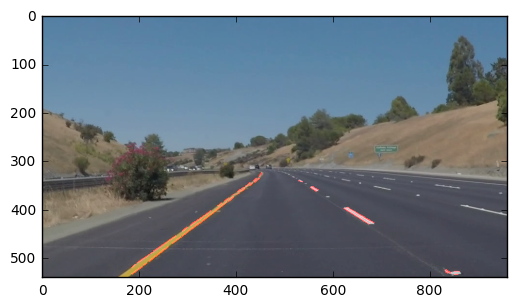

In [99]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [100]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:25<00:00, 10.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 16 s, sys: 3.04 s, total: 19 s
Wall time: 27.7 s


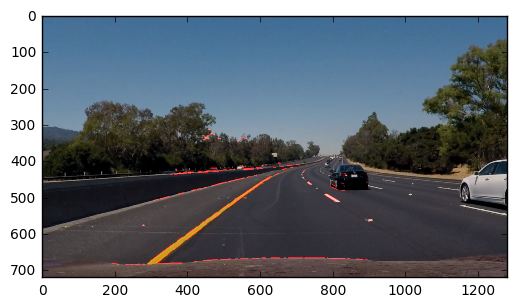

In [101]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [102]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))